## Overview

This notebook implements the **GraphAgent** system — a structured, multi-agent or graph-based approach for orchestrating tasks, tools, and data flows in AI pipelines.

It contains both explanatory markdown sections and executable Python code cells that together form the logic of the project.

The purpose of this README is to:

- Give an overview of the project goals and structure.

- Summarize the functionality of each cell in the notebook.

- Provide context for understanding how each part fits into the bigger picture.

---

## Requirements

Before running the notebook, ensure you have:

- Python 3.10+

- Required Python packages installed (check the import statements in the notebook)

- Access to any APIs or services used (API keys in `.env` file)

---

### Code Implementation

_Description:_ This cell contains Python code related to the project's logic.

In [51]:
from io import BytesIO
from typing import Mapping, Sequence, Optional, Dict, Any, Tuple
import base64
import matplotlib.pyplot as plt
import numpy as np

from haystack.components.agents import Agent
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.dataclasses import ChatMessage
from haystack.tools import ComponentTool
from haystack.core.component import component, OutputSocket, InputSocket
from haystack.utils import Secret

## Universal Chart Generator

This function creates **multiple types of charts** from a unified API and returns them as **Base64-encoded images** (optionally as Data URLs). It supports **Cartesian, statistical, and circular chart types** using Matplotlib.

### Supported `chart_type` values:

* **Cartesian**: `'line'`, `'step'`, `'scatter'`, `'area'`, `'bar'`, `'barh'`, `'stacked_bar'`
* **Statistical**: `'hist'`, `'box'`
* **Circular**: `'pie'`, `'donut'`

### Data format requirements:

* **Cartesian (single series)**:
  `{"x": [...], "y": [...]}`
* **Cartesian (multiple series)**:
  `{"x": [...], "series": {"Label A": [...], "Label B": [...]}}`
* **Histogram**:
  `{"y":[...]}` *(single)* or `{"series":{"A":[...], "B":[...]}, "bins": int}` *(multi)*
* **Box Plot**:
  `{"series":{"Group A":[...], "Group B":[...]}}`
* **Pie/Donut**:
  `{"labels":[...], "sizes":[...], "explode":[...]}` *(optional)*

### Key features:

* Automatic axis labeling, legends, and grid support (except for pie/donut).
* Dimension and alignment validation for inputs.
* Supports both **single** and **multiple series** in most chart types.
* Returns output as **Base64** string for easy embedding in HTML, markdown, or APIs.

### Parameters:

* `data`: Chart data in required format
* `chart_type`: One of the supported chart types (case-insensitive)
* `title`: Chart title
* `x_label`, `y_label`: Axis labels (default `"X-axis"` / `"Y-axis"`)
* `figsize`, `dpi`: Figure size and resolution
* `grid`: Whether to show grid lines
* `image_format`: Output image format (`"png"`, `"jpeg"`, `"webp"`)
* `return_data_url`: If `True`, prepends `data:image/...;base64,`

In [49]:
def generate_chart(
    data: Mapping[str, Any],
    chart_type: str,
    title: str = "",
    *,
    x_label: str = "X-axis",
    y_label: str = "Y-axis",
    figsize: Tuple[float, float] = (8, 5),
    dpi: int = 144,
    grid: bool = True,
    image_format: str = "png",
    return_data_url: bool = False,
) -> str:
    """
    Supported chart_type:
      'line', 'step', 'scatter', 'area',
      'bar', 'barh', 'stacked_bar',
      'hist', 'box',
      'pie', 'donut'

    Data contracts:
      Cartesian (line/step/scatter/area/bar/barh/stacked_bar):
        single:  {"x": [...], "y": [...]}
        multi:   {"x": [...], "series": {"Label A": [...], "Label B": [...], ...}}
      hist:   single -> {"y":[...]}; multi -> {"series":{"A":[...], "B":[...]}} (+ optional "bins": int)
      box:    {"series":{"Group A":[...], "Group B":[...], ...}}
      pie/donut: {"labels":[...], "sizes":[...]} (+ optional "explode":[...])
    """
    chart_type = chart_type.lower().strip()
    allowed = {
        "line", "step", "scatter", "area",
        "bar", "barh", "stacked_bar",
        "hist", "box",
        "pie", "donut",
    }
    if chart_type not in allowed:
        raise ValueError(f"chart_type must be one of {allowed}, got '{chart_type}'.")

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    try:
        # Non-Cartesian types first
        if chart_type in {"hist", "box"}:
            series = data.get("series")
            y = data.get("y")
            if chart_type == "hist":
                bins = int(data.get("bins", 10))
                if series:
                    if not isinstance(series, Mapping):
                        raise ValueError("'series' must be mapping label->sample for 'hist'.")
                    for lbl, sample in series.items():
                        ax.hist(sample, bins=bins, alpha=0.7, label=lbl)
                    ax.legend()
                else:
                    if y is None:
                        raise ValueError("Provide 'y' (single sample) or 'series' for 'hist'.")
                    ax.hist(y, bins=bins, alpha=0.85)
                ax.set_xlabel(x_label)
                ax.set_ylabel("Frequency")

            else:  # box
                if not isinstance(series, Mapping) or not series:
                    raise ValueError("For 'box', provide 'series' mapping label->sample.")
                labels = list(series.keys())
                samples = [series[k] for k in labels]
                ax.boxplot(samples, labels=labels, vert=True)
                ax.set_xlabel(x_label)
                ax.set_ylabel(y_label)

        elif chart_type in {"pie", "donut"}:
            labels = data.get("labels")
            sizes = data.get("sizes")
            if labels is None or sizes is None or len(labels) != len(sizes):
                raise ValueError("For 'pie'/'donut' provide matching 'labels' and 'sizes'.")
            explode = data.get("explode")
            wedgeprops = {"width": 0.4} if chart_type == "donut" else {}
            ax.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90,
                   explode=explode, wedgeprops=wedgeprops)
            ax.axis("equal")

        else:
            # Cartesian charts
            if "x" not in data:
                raise ValueError("data must contain 'x' for this chart type.")
            x = data["x"]
            series: Optional[Dict[str, Sequence]] = data.get("series")
            y = data.get("y")

            if series is None and y is None:
                raise ValueError("Provide either 'y' or 'series' for this chart type.")

            # Alignment checks (skip for bars where we handle widths/indices)
            if chart_type not in {"bar", "barh", "stacked_bar"}:
                if series:
                    for lbl, yv in series.items():
                        if len(yv) != len(x):
                            raise ValueError(f"Series '{lbl}' length {len(yv)} != len(x) {len(x)}.")
                else:
                    if len(y) != len(x):
                        raise ValueError(f"len(y) {len(y)} != len(x) {len(x)}.")

            if chart_type == "bar":
                if series is None:
                    ax.bar(x, y)
                else:
                    n = len(series)
                    idx = np.arange(len(x))
                    w = 0.8 / max(n, 1)
                    labels = list(series.keys())
                    for i, lbl in enumerate(labels):
                        ax.bar(idx + (i - (n - 1) / 2) * w, series[lbl], width=w, label=lbl)
                    ax.set_xticks(idx)
                    ax.set_xticklabels([str(v) for v in x])
                    ax.legend()

            elif chart_type == "barh":
                if series is None:
                    ax.barh(x, y)
                else:
                    n = len(series)
                    idx = np.arange(len(x))
                    h = 0.8 / max(n, 1)
                    labels = list(series.keys())
                    for i, lbl in enumerate(labels):
                        ax.barh(idx + (i - (n - 1) / 2) * h, series[lbl], height=h, label=lbl)
                    ax.set_yticks(idx)
                    ax.set_yticklabels([str(v) for v in x])
                    ax.legend()

            elif chart_type == "stacked_bar":
                if series is None:
                    ax.bar(x, y)
                else:
                    labels = list(series.keys())
                    idx = np.arange(len(x))
                    bottom = np.zeros(len(x))
                    for lbl in labels:
                        vals = np.array(series[lbl])
                        ax.bar(idx, vals, bottom=bottom, label=lbl)
                        bottom += vals
                    ax.set_xticks(idx)
                    ax.set_xticklabels([str(v) for v in x])
                    ax.legend()

            elif chart_type == "line":
                if series is None:
                    ax.plot(x, y)
                else:
                    for lbl, yv in series.items():
                        ax.plot(x, yv, label=lbl)
                    ax.legend()

            elif chart_type == "step":
                if series is None:
                    ax.step(x, y, where="mid")
                else:
                    for lbl, yv in series.items():
                        ax.step(x, yv, where="mid", label=lbl)
                    ax.legend()

            elif chart_type == "scatter":
                if series is None:
                    ax.scatter(x, y)
                else:
                    for lbl, yv in series.items():
                        ax.scatter(x, yv, label=lbl)
                    ax.legend()

            elif chart_type == "area":
                if series is None:
                    ax.fill_between(range(len(x)), y)
                    ax.set_xticks(list(range(len(x))))
                    ax.set_xticklabels([str(v) for v in x])
                else:
                    labels = list(series.keys())
                    ys = [series[lbl] for lbl in labels]
                    xs = list(range(len(x)))
                    ax.stackplot(xs, *ys, labels=labels)
                    ax.set_xticks(xs)
                    ax.set_xticklabels([str(v) for v in x])
                    ax.legend()

            ax.set_xlabel(x_label)
            ax.set_ylabel(y_label)

        if title:
            ax.set_title(title)
        if grid and chart_type not in {"pie", "donut"}:
            ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.6)

        fig.tight_layout()
        buf = BytesIO()
        fig.savefig(buf, format=image_format, bbox_inches="tight")
        buf.seek(0)
        img_b64 = base64.b64encode(buf.read()).decode("utf-8")
        return f"data:image/{image_format};base64,{img_b64}" if return_data_url else img_b64
    finally:
        plt.close(fig)


### `show_b64` — Quick Base64 Image Preview  
Decodes a Base64-encoded image and displays it inline using Matplotlib.  
Useful for visualizing charts or images generated in memory without saving to disk.

In [46]:
def show_b64(b64_img, fmt="png"):
    img_bytes = base64.b64decode(b64_img)
    img = plt.imread(BytesIO(img_bytes), format=fmt)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

### Example
Generates and display charts.

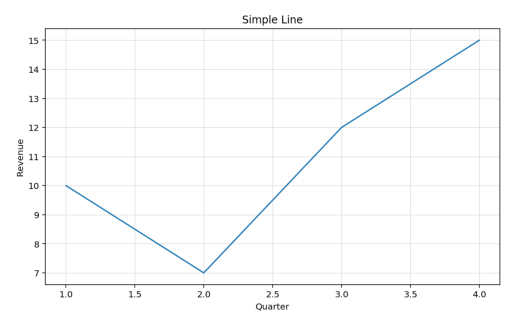

In [47]:
line_single = generate_chart(
    {"x": [1,2,3,4], "y": [10, 7, 12, 15]},
    chart_type="line",
    title="Simple Line",
    x_label="Quarter",
    y_label="Revenue",
)
show_b64(line_single)

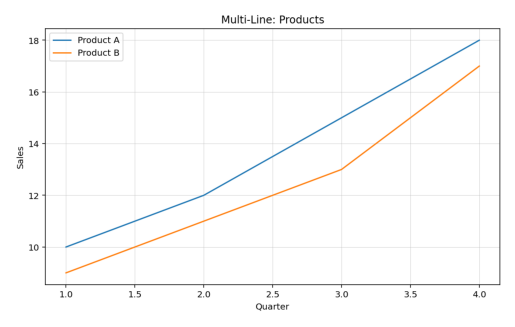

In [30]:
line_multi = generate_chart(
    {"x": [1,2,3,4], "series": {"Product A":[10,12,15,18], "Product B":[9,11,13,17]}},
    chart_type="line",
    title="Multi-Line: Products",
    x_label="Quarter",
    y_label="Sales",
)
show_b64(line_multi)

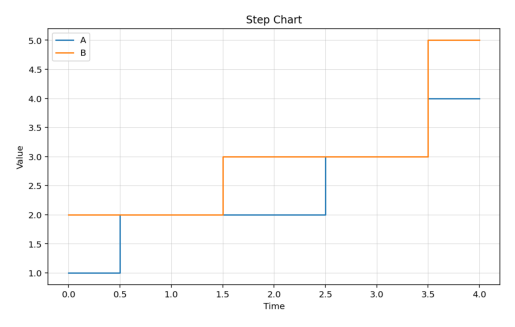

In [31]:
step_multi = generate_chart(
    {"x": [0,1,2,3,4], "series": {"A":[1,2,2,3,4], "B":[2,2,3,3,5]}},
    chart_type="step",
    title="Step Chart",
    x_label="Time",
    y_label="Value",
)
show_b64(step_multi)

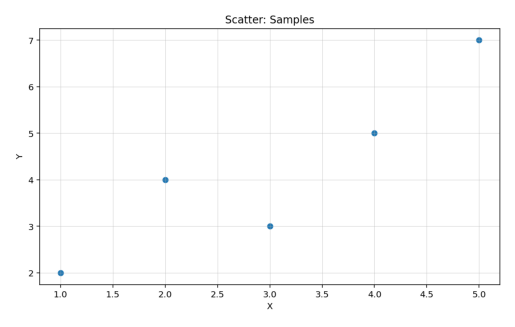

In [32]:
scatter_single = generate_chart(
    {"x": [1,2,3,4,5], "y": [2,4,3,5,7]},
    chart_type="scatter",
    title="Scatter: Samples",
    x_label="X",
    y_label="Y",
)
show_b64(scatter_single)

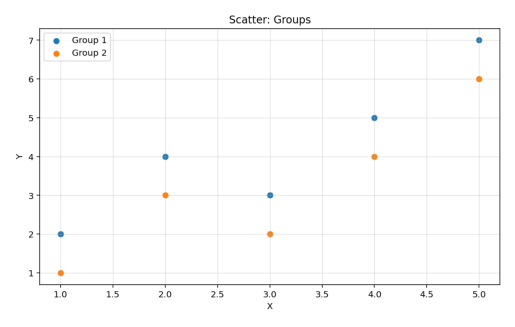

In [33]:
scatter_multi = generate_chart(
    {"x": [1,2,3,4,5], "series": {"Group 1":[2,4,3,5,7], "Group 2":[1,3,2,4,6]}},
    chart_type="scatter",
    title="Scatter: Groups",
    x_label="X",
    y_label="Y",
)
show_b64(scatter_multi)

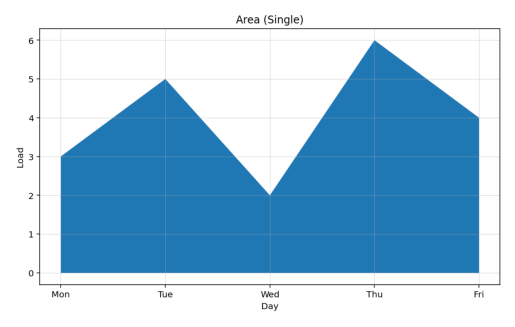

In [34]:
area_single = generate_chart(
    {"x": ["Mon","Tue","Wed","Thu","Fri"], "y": [3,5,2,6,4]},
    chart_type="area",
    title="Area (Single)",
    x_label="Day",
    y_label="Load",
)
show_b64(area_single)

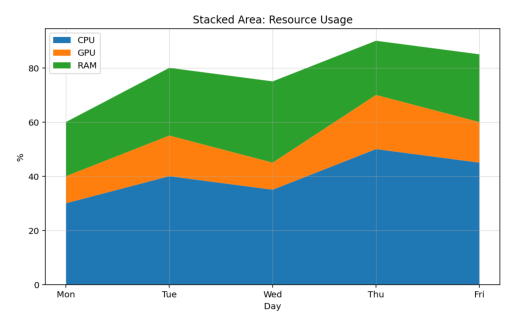

In [35]:
area_stacked = generate_chart(
    {"x": ["Mon","Tue","Wed","Thu","Fri"],
     "series": {"CPU":[30,40,35,50,45], "GPU":[10,15,10,20,15], "RAM":[20,25,30,20,25]}},
    chart_type="area",
    title="Stacked Area: Resource Usage",
    x_label="Day",
    y_label="%",
)
show_b64(area_stacked)

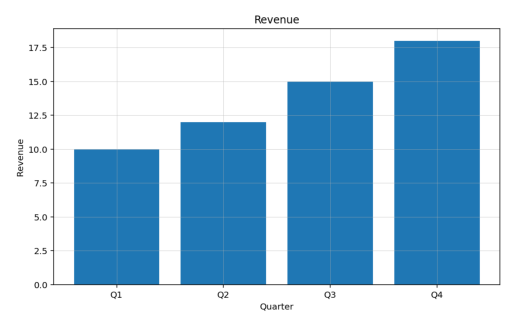

In [36]:
bar_single = generate_chart(
    {"x": ["Q1","Q2","Q3","Q4"], "y": [10,12,15,18]},
    chart_type="bar",
    title="Revenue",
    x_label="Quarter",
    y_label="Revenue",
)
show_b64(bar_single)

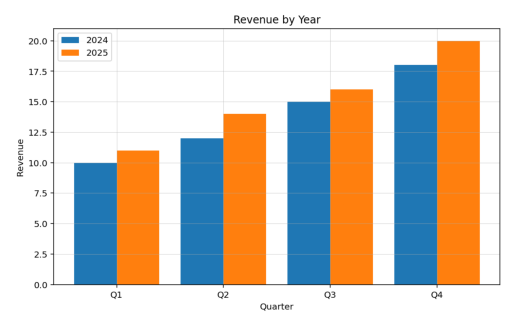

In [37]:
grouped_bar = generate_chart(
    {"x": ["Q1","Q2","Q3","Q4"], "series": {"2024":[10,12,15,18], "2025":[11,14,16,20]}},
    chart_type="bar",
    title="Revenue by Year",
    x_label="Quarter",
    y_label="Revenue",
)
show_b64(grouped_bar)

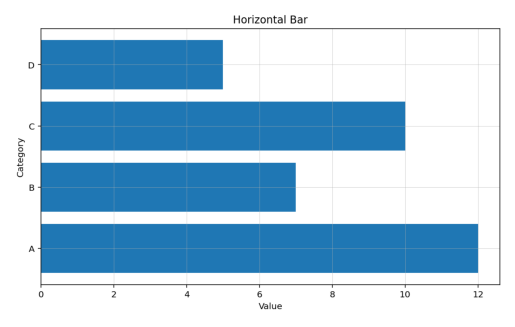

In [38]:
barh_single = generate_chart(
    {"x": ["A","B","C","D"], "y": [12,7,10,5]},
    chart_type="barh",
    title="Horizontal Bar",
    x_label="Value",
    y_label="Category",
)
show_b64(barh_single)

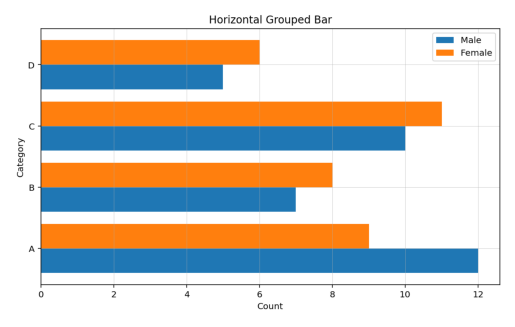

In [39]:
barh_grouped = generate_chart(
    {"x": ["A","B","C","D"], "series": {"Male":[12,7,10,5], "Female":[9,8,11,6]}},
    chart_type="barh",
    title="Horizontal Grouped Bar",
    x_label="Count",
    y_label="Category",
)
show_b64(barh_grouped)

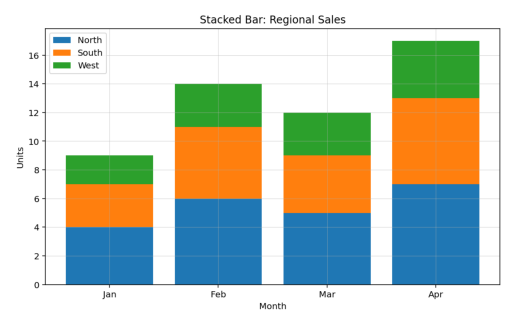

In [40]:
stacked_bar = generate_chart(
    {"x": ["Jan","Feb","Mar","Apr"],
     "series": {"North":[4,6,5,7], "South":[3,5,4,6], "West":[2,3,3,4]}},
    chart_type="stacked_bar",
    title="Stacked Bar: Regional Sales",
    x_label="Month",
    y_label="Units",
)
show_b64(stacked_bar)

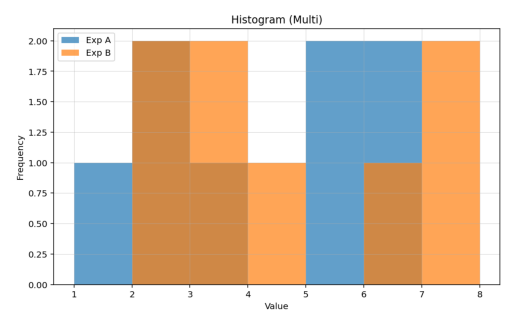

In [41]:
hist_multi = generate_chart(
    {"series": {"Exp A":[1,2,2,3,5,5,6,7], "Exp B":[2,2,3,3,4,6,7,8]}, "bins": 6},
    chart_type="hist",
    title="Histogram (Multi)",
    x_label="Value",
)
show_b64(hist_multi)

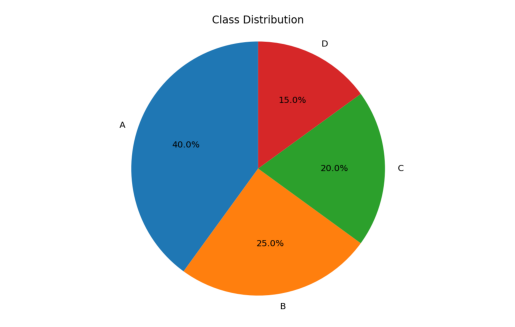

In [42]:
pie_chart = generate_chart(
    {"labels": ["A","B","C","D"], "sizes": [40,25,20,15]},
    chart_type="pie",
    title="Class Distribution",
)
show_b64(pie_chart)

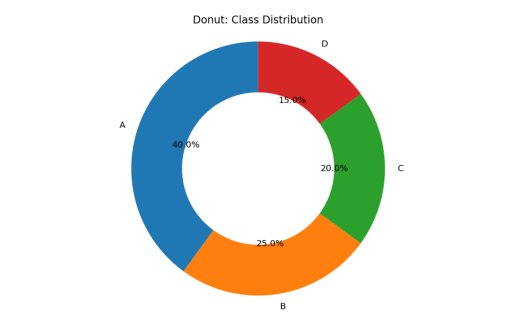

In [43]:
donut_chart = generate_chart(
    {"labels": ["A","B","C","D"], "sizes": [40,25,20,15]},
    chart_type="donut",
    title="Donut: Class Distribution",
)
show_b64(donut_chart)